In [122]:
import cvxpy as cp
import numpy as np
import os
import pickle
import re
import scipy
import seaborn as sns

from itertools import product
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

In [478]:
# Load the data
data_dir = "../data/AAMAS"
dset_idx = 3
which_dset = "00037-0000000%d.cat" % dset_idx

dset_sizes = [(201, 613), (161, 442), (667, 526)]
# Yes, maybe, no answer, no
rating_scores = [1.0, .5, 0.0, -1.0]

if dset_idx == 3:
    # Yes, maybe, no, conflict
    rating_scores = [1.0, .5, -1.0, 0.0]

agent_idx = 0
with open(os.path.join(data_dir, which_dset)) as f:
    ratings = np.zeros(dset_sizes[dset_idx-1])
    for l in f.readlines():
        if not l.startswith("#"):
            l = re.sub("[0-9]*: ", "", l)
            bracket_list = re.compile("\{[0-9, ]*\}|[0-9]+")
            lists = bracket_list.findall(l)
            if len(lists) != 4:
                print(lists)
                print(l)
                print("PROBLEM")
            for idx, list_of_prefs in enumerate(lists):
                if list_of_prefs != '{}':
                    list_of_prefs = re.sub("[\{\}]", "", list_of_prefs)
                    prefs = [int(x)-1 for x in list_of_prefs.split(",")]
                    ratings[agent_idx, prefs] = rating_scores[idx]
            agent_idx += 1

In [479]:
np.save(os.path.join(data_dir, "ratings_%d.npy" % dset_idx), ratings)

In [480]:
# Binarize the labels
binary_ratings = ratings.copy()

In [481]:
binary_ratings[ratings > .1] = 1

<Axes: ylabel='Count'>

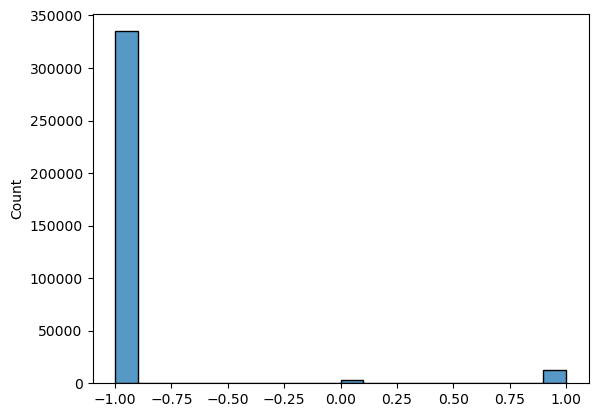

In [482]:
sns.histplot(binary_ratings.flatten())

In [483]:
gen = np.random.default_rng(seed=0)

In [484]:
# TODO: We can apply a mask to have a held-out test set
test_frac = .2
coi_mask = np.load(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx))
held_out_for_test = gen.random(binary_ratings.shape) < coi_mask*np.abs(binary_ratings)*test_frac

In [485]:
np.sum(held_out_for_test)

18383

In [486]:
import torch
n_rows, n_cols = binary_ratings.shape
k = 20
U = torch.tensor(gen.normal(size=(n_rows, k)), requires_grad=True)
V = torch.tensor(gen.normal(size=(k, n_cols)), requires_grad=True)

# X = torch.tensor(gen.normal(size=(n_rows, n_cols)), requires_grad=True)
# y = torch.tensor(gen.normal(size=(n_rows, n_cols)), requires_grad=True)

In [487]:
observed_ones = np.where((1-held_out_for_test)*(binary_ratings > .9)*coi_mask)
observed_minus_ones = np.where((1-held_out_for_test)*(binary_ratings < -.9)*coi_mask)

In [488]:
xe_loss = torch.nn.CrossEntropyLoss()

In [489]:
# loss = -torch.sum(torch.log(torch.special.expit(X[observed_ones])))
# loss = -torch.sum(torch.log(torch.special.expit(1-X[observed_minus_ones])))
# loss = xe_loss(X[observed_ones], torch.ones(X[observed_ones].shape))
# # loss += 0.1 * cp.norm(X, 'nuc')
# loss += .1 * torch.trace(torch.sqrt(X.T @ X))

step_size = .1
optimizer = torch.optim.Adam([U, V], lr=step_size)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

In [490]:
for i in tqdm(range(int(3000))):
    optimizer.zero_grad()
    x_pred = torch.special.expit(torch.mm(U, V))
    tgt_ones = torch.ones(ratings[observed_ones].shape).to(torch.long)
    loss = xe_loss(torch.concat((-x_pred[observed_ones].reshape((-1,1)), x_pred[observed_ones].reshape((-1, 1))), axis=1), tgt_ones)
    tgt_zeros = torch.zeros(ratings[observed_minus_ones].shape).to(torch.long)
    loss += xe_loss(torch.concat((-x_pred[observed_minus_ones].reshape((-1,1)), x_pred[observed_minus_ones].reshape((-1, 1))), axis=1), tgt_zeros)
    loss += .0005*torch.norm(U)
    loss += .0005*torch.norm(V)
#     loss = xe_loss(torch.concat((y[observed_ones].reshape((1, -1)), X[observed_ones].reshape((1, -1))), axis=0).T, torch.ones(X[observed_ones].shape).to(torch.long))
# #     loss += xe_loss(X[observed_minus_ones], torch.zeros(X[observed_minus_ones].shape))
#     loss += xe_loss(torch.concat((y[observed_minus_ones].reshape((1, -1)), X[observed_minus_ones].reshape((1, -1))), axis=0).T, torch.zeros(X[observed_minus_ones].shape).to(torch.long))

#     loss = -torch.sum(torch.log(torch.special.expit(1-X[observed_minus_ones])))
    # loss += 0.1 * cp.norm(X, 'nuc')
#     loss += .1 * torch.trace(torch.sqrt(torch.mm(X.T, X)))
    if i % 1000 == 0:
        print(loss)

    loss.backward()
    optimizer.step()
#     scheduler.step(loss)

  0%|          | 0/3000 [00:00<?, ?it/s]

tensor(1.8659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.9582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.9572, dtype=torch.float64, grad_fn=<AddBackward0>)


In [491]:
pred_mat = torch.special.expit(torch.mm(U, V))

<Axes: ylabel='Count'>

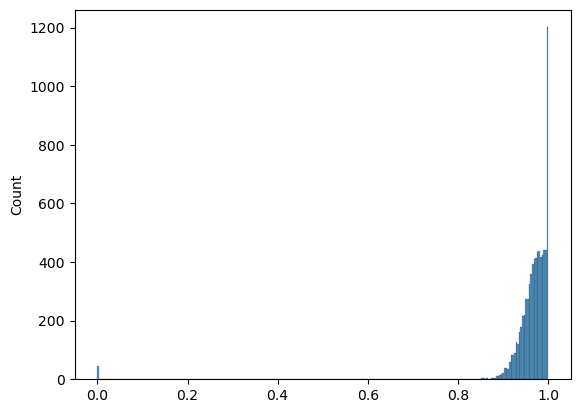

In [492]:
sns.histplot(pred_mat[observed_ones].flatten().detach().numpy())

<Axes: ylabel='Count'>

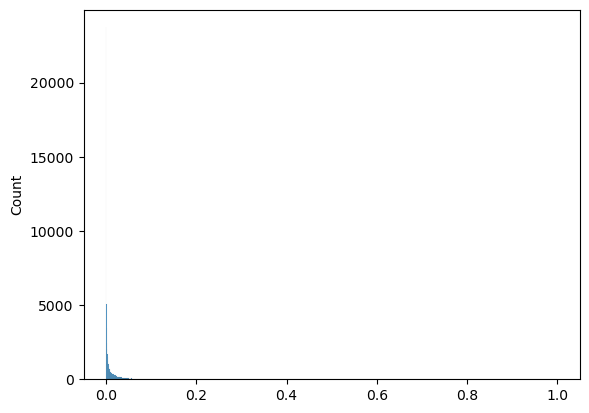

In [493]:
sns.histplot(pred_mat[observed_minus_ones].flatten().detach().numpy())

<Axes: ylabel='Count'>

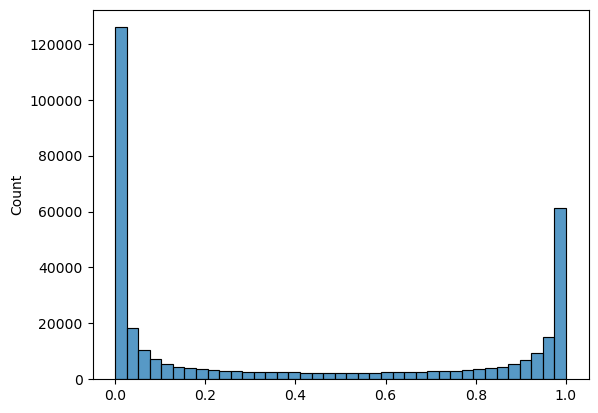

In [494]:
sns.histplot(pred_mat.flatten().detach().numpy())

In [495]:
# Now compute the bound on the cross entropy loss for each group under each delta value
groups = np.load(os.path.join(data_dir, "groups_%d.npy" % dset_idx))
coi_mask = np.load(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx))

In [496]:
# For each group, pull out the entries that were held out. Then compute mean and standard deviation of cross entropy loss
ngroups = len(set(groups))

means = []
stds = []

nonaggloss = torch.nn.CrossEntropyLoss(reduction='none')

for gidx in range(ngroups):
    cm = coi_mask[:, np.where(groups==gidx)[0]]
    test_entries = binary_ratings[:, np.where(groups == gidx)[0]]
    predictions = pred_mat[:, np.where(groups == gidx)[0]]
    observed_entries = np.where((np.abs(test_entries) > .1)*cm)
    print(observed_entries[0].shape)
#     print(test_entries[observed_entries])
#     print(predictions[observed_entries])
    tgt = test_entries[observed_entries]
    tgt[tgt == -1] = 0
    tgt = torch.tensor(tgt, dtype=int)
#     print(tgt)
    
    p = predictions[observed_entries]
    p0 = torch.reshape(1-p, (-1,1))
    p1 = torch.reshape(p, (-1,1))
    preds_tensor = torch.concat((p0, p1), 1)
#     print(preds_tensor)
    preds_tensor = torch.log(preds_tensor)
#     print(preds_tensor.shape)
    
    xe_test = nonaggloss(preds_tensor, tgt)
    xe_test = xe_test.detach().cpu().numpy()
    
    mean, std = np.mean(xe_test), np.std(xe_test, ddof=1)
    print(mean, std)
    means.append(mean)
    stds.append(std)
#     print(test_entries.shape)

(17510,)
0.1766660746168001 1.0155549891496527
(48005,)
0.0954727470320961 0.7230042856828803
(13760,)
0.08742876414730325 0.5554445370618132
(13811,)
0.08419724586706977 0.5248353960023685


In [497]:
n_groups = len(set(groups))

delta_to_normal_bd = {}
for delta in [.3, .2, .1, .05]:
    delta_to_normal_bd[delta] = []
    for gidx in range(n_groups):
        ub = scipy.stats.norm.ppf(1-(delta/n_groups), loc=means[gidx], scale=stds[gidx])
        delta_to_normal_bd[delta].append(ub)
#     xis.append(xe_test.item())

In [498]:
delta_to_normal_bd

{0.3: [1.6385894419662876,
  1.1362601698959809,
  0.8870086556086252,
  0.8397143154749266],
 0.2: [1.8471053818882692,
  1.2847089686390403,
  1.0010537255038081,
  0.9474746505340778],
 0.1: [2.167117277670085,
  1.51253510763865,
  1.1760800521979804,
  1.112855719843529],
 0.05: [2.452933797329644,
  1.7160165250317705,
  1.3324036645509183,
  1.260564734010401]}

In [499]:
np.save(os.path.join(data_dir, "prob_up_%d.npy" % dset_idx), pred_mat.detach().numpy())

In [500]:
pickle.dump(delta_to_normal_bd, open(os.path.join(data_dir, "delta_to_normal_bd_%d.pkl" % dset_idx), 'wb'))

In [80]:
# Use https://dl.acm.org/doi/pdf/10.1145/1553374.1553452 to get prob model for CVaR objectives
gen = np.random.default_rng(seed=0)
q = 20
x = gen.normal(loc=0, scale=1e-3, size=(ratings.shape[0], q))
sig = .05

In [81]:
x

array([[ 1.25730221e-04, -1.32104863e-04,  6.40422650e-04, ...,
        -3.16300156e-04,  4.11630536e-04,  1.04251337e-03],
       [-1.28534663e-04,  1.36646347e-03, -6.65194673e-04, ...,
        -1.29613634e-04,  7.83975470e-04,  1.49343115e-03],
       [-1.25906553e-03,  1.51392377e-03,  1.34587542e-03, ...,
         6.96042724e-04, -1.18411797e-03, -6.61702572e-04],
       ...,
       [-9.02690927e-04,  9.37403974e-04,  9.56067063e-04, ...,
         1.11817382e-03, -1.54199682e-04,  2.54180358e-05],
       [ 2.62712982e-04,  2.24919949e-04,  8.63618968e-05, ...,
         4.42117853e-04,  9.69861933e-04, -1.11241352e-03],
       [-7.35110772e-04, -5.93191918e-04,  1.13752576e-04, ...,
        -7.00356874e-04, -4.90968554e-04, -1.48581079e-03]])

In [82]:
n_iter = 100

lr = 1e-4

for i in tqdm(range(n_iter)):
#     item_idx = gen.integers(ratings.shape[1])
    for item_idx in range(ratings.shape[1]):
        # pick out the users where this item was rated
        observed = np.where(np.abs(ratings[:, item_idx]) > 1e-4)[0]
#         print(observed)
#         print(x[observed])
        if len(observed):
            Cj = np.matmul(x[observed], x[observed].T) + (sig**2)*np.eye(len(observed))
#             print(Cj)
            Cinv = np.linalg.inv(Cj)
            yobs = ratings[observed, item_idx]
    #         print(yobs)
            G = np.outer(yobs, yobs)
            G = np.matmul(Cinv, G)
            G = np.matmul(G, Cinv)
            G -= Cinv
            grad = np.matmul(-G, x[observed])

            x[observed] -= lr*grad

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
# For each item, we can sample the rating for each user. It is by section 3.1, the prediction of user rating section.
print(x.shape)
k = np.matmul(x, x.T)
s = k + (sig**2)*np.eye(k.shape[0])
mu_matrix = np.zeros(ratings.shape)
zeta_matrix = np.zeros(ratings.shape)
for item_idx in tqdm(range(ratings.shape[1])):
    for user_idx in range(ratings.shape[0]):
        observed = np.where(np.abs(ratings[:, item_idx]) > 1e-4)[0]
        sobs = s[observed, :][:, observed]
        final_s = np.matmul(np.linalg.inv(sobs), k[observed, user_idx])
        mu = np.dot(final_s, ratings[observed, item_idx])
        mu_matrix[user_idx, item_idx] = mu
        zeta_matrix[user_idx, item_idx] = k[user_idx, user_idx] + sig**2 - np.dot(k[observed, user_idx], final_s)
        
# cov_mat = np.matmul(x, x.T) + (sig**2)*np.eye(x.shape[0])
# zero_vec = np.zeros(x.shape[0])

(667, 20)


  0%|          | 0/526 [00:00<?, ?it/s]

In [84]:
np.save(os.path.join(data_dir, "mu_matrix_%d.npy" % dset_idx), mu_matrix)
np.save(os.path.join(data_dir, "zeta_matrix_%d.npy" % dset_idx), zeta_matrix)

In [93]:
ratings[np.where(ratings > .5)].shape

(6665,)

In [94]:
mu_matrix[np.where(ratings == 1)][:300]

array([-7.82595666e-01, -9.49701474e-01, -8.63080155e-01, -7.11956223e-01,
       -6.62208094e-01, -5.55182234e-01,  3.65711030e-01,  6.88942575e-01,
        1.31609686e-01, -7.93921557e-01,  3.11553308e-01,  4.97713798e-01,
        6.16549406e-01, -5.88141446e-01,  7.99683303e-01, -4.09261306e-01,
       -3.58425982e-01, -1.44308933e-01, -7.85643181e-01,  9.15239815e-01,
        4.12078698e-01,  8.53442885e-01,  1.45487714e-01,  1.38522053e-01,
        1.12499062e+00, -5.72806046e-01,  6.43900552e-01, -4.78208311e-01,
       -2.08070794e-01, -5.61838505e-01, -5.11127539e-01, -4.26639376e-01,
        2.71069772e-01,  8.73428142e-01, -1.30637189e-01,  1.10271852e+00,
       -2.54017071e-01, -5.12118856e-01,  4.39566798e-02,  1.23874228e+00,
       -1.71406061e-01, -3.12844073e-01,  1.07128820e+00,  1.04576835e+00,
       -1.97453317e-01,  1.59088408e-01,  3.70741113e-01,  8.84302374e-01,
       -3.36355965e-01,  1.99348149e+00,  1.89502857e+00,  2.76547596e-01,
        7.80480377e-01, -

<Axes: ylabel='Count'>

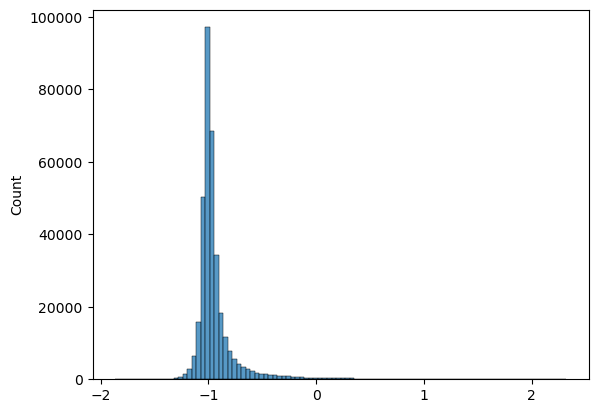

In [87]:
sns.histplot(mu_matrix.flatten(), bins=100)

<Axes: ylabel='Count'>

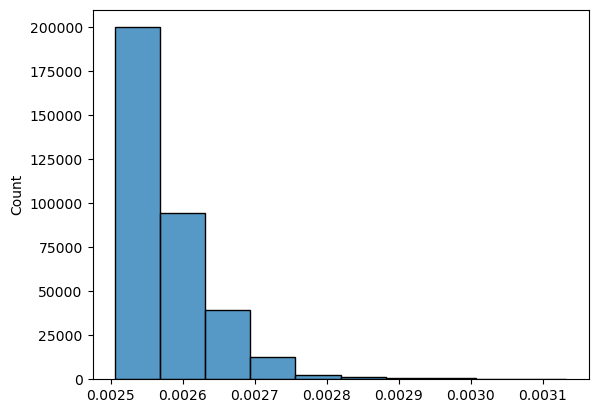

In [88]:
sns.histplot(zeta_matrix.flatten(), bins=10)

In [89]:
np.max(zeta_matrix, axis=0)

array([0.00296505, 0.00296334, 0.00296435, 0.00295996, 0.00295934,
       0.00296299, 0.00295931, 0.0029594 , 0.00296597, 0.00297264,
       0.00295932, 0.00296923, 0.00296814, 0.00295931, 0.00296012,
       0.00295932, 0.00296251, 0.00295974, 0.00296325, 0.00297145,
       0.00295931, 0.0030498 , 0.00295968, 0.00295931, 0.00297273,
       0.00295999, 0.00295989, 0.00296557, 0.0029594 , 0.00306311,
       0.00296902, 0.00296407, 0.00295937, 0.0029602 , 0.00296237,
       0.00296058, 0.00295931, 0.00295931, 0.00295931, 0.00295955,
       0.0029636 , 0.00295938, 0.00295931, 0.00296003, 0.00296141,
       0.00296319, 0.00296025, 0.00296027, 0.00296245, 0.00296156,
       0.00295938, 0.00296021, 0.00296334, 0.00295934, 0.00295954,
       0.00296074, 0.00295932, 0.00295931, 0.00296271, 0.00310144,
       0.00296818, 0.00295972, 0.00296031, 0.00295961, 0.00295976,
       0.00296168, 0.00295946, 0.00295964, 0.00295935, 0.0029677 ,
       0.0029684 , 0.00295998, 0.00296061, 0.00296353, 0.00297

# Now we'll cluster these and make groups for both getting COIs and for the GESW

In [346]:
# cluster ratings
dset_idx = 3
ratings = np.load(os.path.join(data_dir, "ratings_%d.npy" % dset_idx))

ratings[ratings < 0] = 0
ratings[ratings > 0] = 1

<Axes: ylabel='Count'>

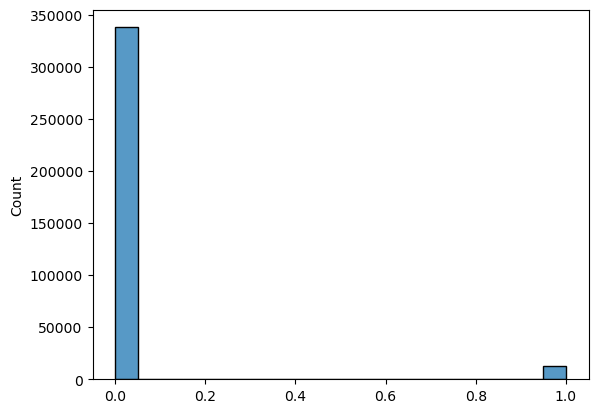

In [347]:
sns.histplot(ratings.flatten())

In [348]:
# from sklearn.cluster import SpectralBiclustering, KMeans
from scipy.spatial.distance import cdist
from sklearn.manifold import SpectralEmbedding
n, m = ratings.shape
affinities = np.zeros((n+m, n+m))
affinities[:n, :][:, n:] = ratings
affinities[n:, :][:, :n] = ratings.T
affinities += 1e-5
embedding = SpectralEmbedding(n_components=5, affinity='precomputed')
X_transformed = embedding.fit_transform(affinities)
# >>> X_transformed.shape
# clustering = SpectralBiclustering(n_clusters=4, random_state=1, method="log").fit(ratings)

In [349]:
X_transformed.shape

(1193, 5)

In [350]:
k=4
clusters = KMeans(n_clusters=k, random_state=0).fit(X_transformed)

In [351]:
rc = clusters.labels_[:n]
cc = clusters.labels_[n:]
print(Counter(rc), Counter(cc))

Counter({1: 404, 0: 138, 3: 72, 2: 53}) Counter({1: 289, 0: 145, 3: 59, 2: 33})


In [352]:
clusters.cluster_centers_

array([[-0.00476764,  0.00856899, -0.00025601,  0.00232498, -0.00056852],
       [ 0.00165742, -0.0029007 , -0.00056019, -0.0007972 , -0.00300265],
       [-0.00526398, -0.00877064, -0.00948956,  0.01381259,  0.01222643],
       [-0.00437072, -0.00204141,  0.00790982, -0.00963924,  0.01047929]])

In [353]:
import gurobipy as gp

In [354]:
# Iterate between assigning row and column cluster ids where each cluster must have at least a certain number of points,
# then recompute cluster centers.
centers = clusters.cluster_centers_
row_embs = X_transformed[:n]
col_embs = X_transformed[n:]

min_rc_size = int(.8*(n/k))
min_cc_size = int(.8*(m/k))

In [355]:
print(min_rc_size, min_cc_size)

133 105


In [356]:
for _ in range(100):
    # First we reassign with balance contraints
    row_dist_to_ctrs = cdist(row_embs, centers)
    col_dist_to_ctrs = cdist(col_embs, centers)
    
    m = gp.Model()

    matching_rows = m.addMVar(row_dist_to_ctrs.shape, vtype=gp.GRB.BINARY)
    matching_cols = m.addMVar(col_dist_to_ctrs.shape, vtype=gp.GRB.BINARY)
    
    m.addConstr(matching_rows.sum(axis=1) == 1)
    m.addConstr(matching_rows.sum(axis=0) >= min_rc_size)
    
    m.addConstr(matching_cols.sum(axis=1) == 1)
    m.addConstr(matching_cols.sum(axis=0) >= min_cc_size)

    obj = (matching_rows*row_dist_to_ctrs).sum() + (matching_cols*col_dist_to_ctrs).sum()

    m.setObjective(obj)
    m.optimize()
    
    print(obj.getValue())

    row_clusters = np.where(matching_rows.x)[1]
    col_clusters = np.where(matching_cols.x)[1]
    
    # Then we recompute cluster centers
    for cidx in range(k):
        row_pts = row_embs[np.where(row_clusters == cidx)[0], :]
        col_pts = col_embs[np.where(col_clusters == cidx)[0], :]
        centers[cidx] = np.mean(np.vstack((row_pts, col_pts)), axis=0)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x6aaeefaa
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-04, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 23.1191924
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 15.9842042
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 14.8954454

Root relaxation: objective 1.337727e+01, 677 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |    


Root relaxation: objective 1.144977e+01, 798 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4497659   11.44977  0.00%     -    0s

Explored 1 nodes (798 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4498 12.0269 13.1713 19.7234 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.144976592236e+01, best bound 1.144976592236e+01, gap 0.0000%
11.44976592236025
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x2be539d2
Variable types: 0 continuous, 4772 integer (4772 bin


Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.04 seconds (0


*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows a

  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.14


Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heur

Presolve time: 0.03s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
T

11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Vari

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.03s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.0

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+0

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.03s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.

Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 co

Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @

11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.05 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Vari

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 19.7232009
Presolve removed 530 rows and 2104 columns
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Found heuristic solution: objective 13.1614818
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 12.0148333

Root relaxation: objective 1.145442e+01, 767 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.0

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.4544210   11.45442  0.00%     -    0s

Explored 1 nodes (767 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.4544 12.0148 13.1615 19.7232 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.145442101657e+01, best bound 1.145442101657e+01, gap 0.0000%
11.454421016565517
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1201 rows, 4772 columns and 9544 nonzeros
Model fingerprint: 0x54f6f440
Variable types: 0 continuous, 4772 integer (4772 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+0

In [357]:
Counter(row_clusters)

Counter({0: 133, 1: 268, 3: 133, 2: 133})

In [358]:
Counter(col_clusters)

Counter({1: 182, 2: 105, 0: 134, 3: 105})

In [359]:
np.save(os.path.join(data_dir, "groups_%d.npy" % dset_idx), col_clusters)

In [360]:
coi_mask = (np.reshape(col_clusters, (1,-1)) == np.reshape(row_clusters, (-1, 1))).astype(int)

In [361]:
np.sum(coi_mask)/coi_mask.size

0.2694318240119484

In [362]:
# np.sum(coi_mask, axis=0)

In [363]:
print(data_dir)

../data/AAMAS


In [364]:
np.save(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx), coi_mask)

In [391]:
k = 4
min_cluster_size = ratings.shape[0]//(k+1)
print(min_cluster_size)

row_clusters = KMeans(n_clusters=4, random_state=0).fit(ratings)
row_centers = row_clusters.cluster_centers_
distance_matrix = cdist(ratings, row_centers)
print(distance_matrix.shape)
# Now match each row to a column such that the total number of rows matching to columns is roughly equal.
m = gp.Model()

matching = m.addMVar(distance_matrix.shape, vtype=gp.GRB.BINARY)
m.addConstr(matching.sum(axis=1) == 1)
m.addConstr(matching.sum(axis=0) >= min_cluster_size)

obj = (matching*distance_matrix).sum()

m.setObjective(obj)
m.optimize()

row_clusters = np.where(matching.x)[1]

133
(667, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 671 rows, 2668 columns and 5336 nonzeros
Model fingerprint: 0x3a919a9e
Variable types: 0 continuous, 2668 integer (2668 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 5782.0563291
Presolve time: 0.02s
Presolved: 671 rows, 2668 columns, 5336 nonzeros
Variable types: 0 continuous, 2668 integer (2668 binary)
Found heuristic solution: objective 5405.9146928

Root relaxation: objective 4.970396e+03, 972 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [392]:
# Do the same for the columns
k = 4
min_cluster_size = ratings.shape[1]//(k+1)
print(min_cluster_size)

col_clusters = KMeans(n_clusters=4, random_state=0).fit(ratings.T)
col_centers = col_clusters.cluster_centers_
distance_matrix = cdist(ratings.T, col_centers)
print(distance_matrix.shape)
# Now match each row to a column such that the total number of rows matching to columns is roughly equal.
import gurobipy as gp
m = gp.Model()

matching = m.addMVar(distance_matrix.shape, vtype=gp.GRB.BINARY)
m.addConstr(matching.sum(axis=1) == 1)
m.addConstr(matching.sum(axis=0) >= min_cluster_size)

obj = (matching*distance_matrix).sum()

m.setObjective(obj)
m.optimize()

col_clusters = np.where(matching.x)[1]

105
(526, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 530 rows, 2104 columns and 4208 nonzeros
Model fingerprint: 0xe6f3e31b
Variable types: 0 continuous, 2104 integer (2104 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 5382.4332668
Presolve time: 0.01s
Presolved: 530 rows, 2104 columns, 4208 nonzeros
Variable types: 0 continuous, 2104 integer (2104 binary)
Found heuristic solution: objective 4943.1623742

Root relaxation: objective 4.601444e+03, 711 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [393]:
Counter(row_clusters)

Counter({1: 133, 2: 133, 0: 268, 3: 133})

In [394]:
Counter(col_clusters)

Counter({2: 105, 1: 105, 3: 211, 0: 105})

In [395]:
# Match up the row clusters with the column clusters. 
# For each pair of clusters, we take the submatrix corresponding to those rows and columns. We can then
# compute the average similarity. Then compute a maximum matching basically.
cluster_link_scores = np.zeros((k,k))
for ridx, cidx in product(range(k), range(k)):
    cluster_link_scores[ridx, cidx] = np.mean(ratings[row_clusters == ridx, :][:, col_clusters == cidx])
print(cluster_link_scores)

[[-0.98798863 -0.92800284 -0.95520611 -0.95800912]
 [-0.7075546  -0.96616541 -0.95363409 -0.95200086]
 [-0.9660222  -0.93161475 -0.7868242  -0.95061112]
 [-0.98191908 -0.77382743 -0.79817401 -0.96142608]]


In [396]:
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(-1*cluster_link_scores)

In [397]:
print(row_ind, col_ind)

[0 1 2 3] [3 0 2 1]


In [398]:
new_col_inds = row_ind[np.argsort(col_ind)]

In [399]:
remapped_col_clusters = [new_col_inds[i] for i in col_clusters]

In [400]:
Counter(remapped_col_clusters)

Counter({2: 105, 3: 105, 0: 211, 1: 105})

In [401]:
np.sum(ratings[:, 13] > .5)

21

In [402]:
ratings.shape

(667, 526)

In [403]:
np.save(os.path.join(data_dir, "groups_%d.npy" % dset_idx), remapped_col_clusters)

In [404]:
coi_mask = (np.reshape(remapped_col_clusters, (1,-1)) == np.reshape(row_clusters, (-1, 1))).astype(int)

In [405]:
np.sum(coi_mask)/coi_mask.size

0.28059069324653263

In [406]:
# np.sum(coi_mask, axis=0)

In [407]:
print(data_dir)

../data/AAMAS


In [408]:
np.save(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx), coi_mask)

In [412]:
import gurobipy as gp
m = gp.Model("TPMS")

mu_matrix = np.load("../data/AAMAS/mu_matrix_%d.npy" % dset_idx)
coi_mask = np.load("../data/AAMAS/coi_mask_%d.npy" % dset_idx)

cs = [3, 2, 2]
ls = [15, 15, 4]
covs_lb = cs[dset_idx-1] * np.ones(mu_matrix.shape[1])
covs_ub = covs_lb
loads = ls[dset_idx - 1] * np.ones(mu_matrix.shape[0])

covs_lb = np.minimum(covs_lb, np.sum(coi_mask, axis=0))


alloc = m.addMVar(mu_matrix.shape, vtype=gp.GRB.BINARY, name='alloc')

m.addConstr(alloc.sum(axis=0) >= covs_lb)
m.addConstr(alloc.sum(axis=0) <= covs_ub)
m.addConstr(alloc.sum(axis=1) <= loads)
m.addConstr(alloc <= coi_mask)

obj = (alloc*mu_matrix).sum()
m.setObjective(obj, gp.GRB.MAXIMIZE)

m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 352561 rows, 350842 columns and 1403368 nonzeros
Model fingerprint: 0x291b64d3
Variable types: 0 continuous, 350842 integer (350842 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective -890.3243179
Presolve removed 352082 rows and 294294 columns
Presolve time: 0.99s
Presolved: 479 rows, 56548 columns, 113096 nonzeros
Found heuristic solution: objective -216.0878651
Variable types: 0 continuous, 56548 integer (56548 binary)
Found heuristic solution: objective -187.9824425

Root relaxation: objective -1.249874e+02, 772 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |    

In [413]:
# np.sum(coi_mask, axis=0)
np.sum(alloc.x, axis=1)

array([0., 4., 4., 3., 2., 0., 4., 1., 4., 3., 0., 4., 4., 0., 0., 4., 4.,
       0., 0., 0., 4., 1., 0., 4., 0., 4., 0., 4., 1., 4., 4., 4., 0., 4.,
       4., 2., 4., 4., 4., 0., 2., 2., 4., 4., 0., 0., 4., 4., 4., 4., 4.,
       4., 4., 2., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 4., 0.,
       4., 4., 4., 0., 0., 4., 0., 0., 0., 0., 4., 0., 0., 4., 0., 0., 0.,
       0., 3., 4., 0., 0., 1., 0., 1., 0., 0., 4., 4., 0., 0., 4., 0., 4.,
       0., 4., 4., 0., 0., 0., 0., 2., 0., 0., 0., 1., 2., 1., 0., 4., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 4., 3., 0., 4., 4., 4.,
       0., 4., 0., 0., 4., 4., 4., 0., 0., 0., 0., 0., 4., 0., 4., 1., 0.,
       4., 0., 4., 0., 2., 4., 0., 4., 4., 2., 0., 4., 0., 0., 4., 0., 4.,
       0., 4., 0., 0., 4., 4., 4., 0., 4., 0., 0., 0., 0., 4., 0., 0., 4.,
       4., 0., 0., 4., 4., 0., 0., 4., 0., 3., 0., 1., 3., 0., 4., 1., 4.,
       1., 0., 4., 4., 0., 1., 4., 3., 0., 0., 4., 4., 4., 0., 0., 0., 1.,
       4., 0., 0., 0., 4.

In [414]:
np.sum(coi_mask, axis=0)[:30]

array([133, 133, 268, 268, 133, 133, 268, 268, 133, 268, 268, 133, 133,
       133, 133, 268, 133, 133, 268, 268, 268, 268, 268, 133, 133, 133,
       268, 133, 268, 133])

In [416]:
np.sum(mu_matrix > 0)

4629

In [430]:
(alloc.x*mu_matrix)[np.where(alloc.x > .5)][:50]

array([ 0.7996833 ,  0.83835331,  1.12499062,  0.8914211 , -0.78597412,
       -0.73600691, -0.80784617, -0.84445602, -0.87994646, -0.51211886,
       -0.89839996,  0.30609427,  0.49783666,  0.15539555,  0.45517362,
       -0.03782739,  0.13930814,  0.76662682, -0.05363163,  0.15707378,
       -0.64195638,  0.61690283, -0.92971344, -0.87478012, -0.90458152,
        0.77843746,  0.53877998,  0.89484714,  1.08641038, -0.0951319 ,
        0.61434734,  0.44087165,  0.98100219,  0.73363947,  0.37858621,
        0.01480599,  0.43697855,  0.19224157,  0.13540374, -0.11962357,
        0.96458317,  0.9670202 ,  0.98330062,  1.91395501,  1.66754085,
       -0.72756361, -0.01379574, -0.18888704, -0.24075622, -0.24784361])

In [424]:
alloc.x[np.where(alloc.x > .5)]

array([1., 1., 1., ..., 1., 1., 1.])

<Axes: ylabel='Count'>

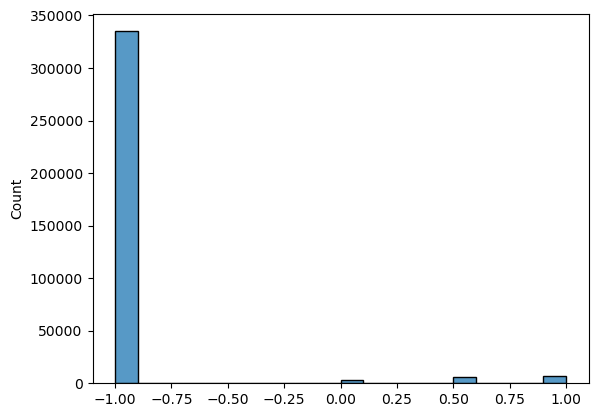

In [431]:
sns.histplot(ratings.flatten())

# Lets figure out what the uncertainty sets look like for each of these 3 conferences

In [439]:

dset_idx = 1
mu = np.load(os.path.join(data_dir, "mu_matrix_%d.npy" % dset_idx))
sig = np.load(os.path.join(data_dir, "zeta_matrix_%d.npy" % dset_idx))
cois = np.load(os.path.join())
print(mu, sig)

[[-1.31569881 -0.00919867 -0.12555626 ...  0.19952523 -0.99439887
  -1.26740124]
 [-0.95484462  0.11860635 -0.39883208 ... -1.02697241 -0.39235444
  -0.66807202]
 [ 0.65053973  0.64019915 -0.07734686 ...  0.70850634  0.51395934
   0.37788927]
 ...
 [-1.36444282 -0.46509636 -0.27187297 ... -0.39057497 -1.32326365
  -0.93794184]
 [ 0.22167786 -0.67683628 -0.04056618 ... -0.07078721 -0.65171542
   0.43151583]
 [ 0.92694799  0.4591538   0.34326559 ...  0.64727505  0.34926279
  -0.01433178]] [[0.30891302 0.2257526  0.04006468 ... 0.2056059  0.00485976 0.07579999]
 [0.32003912 0.17288503 0.05812096 ... 0.0841023  0.02968094 0.13725221]
 [0.0475679  0.05097059 0.00791566 ... 0.00680325 0.01853365 0.03743972]
 ...
 [0.21513276 0.27246977 0.01816245 ... 0.01986167 0.13211829 0.08669199]
 [0.10604284 0.08250018 0.00882556 ... 0.07418879 0.01917057 0.09500311]
 [0.03707423 0.05583834 0.00485573 ... 0.05823314 0.03374338 0.03176694]]


# Old code

In [167]:
# Use logistic matrix factorization to fill in the missing entries
n_rows, n_cols = binary_ratings.shape

X = cp.Variable((n_rows, n_cols))

observed_ones = np.where(binary_ratings > .9)
observed_minus_ones = np.where(binary_ratings < -.9)

loss = -cp.sum(cp.logistic(-X[observed_ones]))
loss -= cp.sum(cp.logistic(X[observed_minus_ones]))
loss -= 0.1 * cp.norm(X, 'nuc')

print(loss.is_dcp())

objective = cp.Maximize(loss)
problem = cp.Problem(objective)
problem.solve(solver=cp.MOSEK, verbose=True)

recovered_matrix = X.value

True
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) May 08 03:01:13 PM: Your problem has 123213 variables, 0 constraints, and 0 parameters.
(CVXPY) May 08 03:01:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 08 03:01:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 08 03:01:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 08 03:01:13 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 08 03:01:13 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Cons

Error: rescode.err_space(1051): 